# Ignore daily correlation. Focus on single-directional travel, and model dispersion of bikes across hours.

1. Given the day of the week, how many bikes do I expect to see?
2. How would these bikes be distributed over the course of the day?

## Findings

- Conjugate priors help a lot
- Sampling daily count then hourly from that works
- Checked correlation between 8am and 9am and found it is much better correlated than when we modelled with gaussian processes. Though real data was still much more correlated.

## Next steps

- Real data 
- Further simulation with weather data

## Weather factors

We want to allow the daily count to change w.r.t. the weather independently of the hourly patterns. For example, the weather may reduce the total number of bikes but not change when people bike (cold temperature), or it may change the hourly distribution with limited impact on daily counts (a very short period of heavy rain).

I also suspect that the morning and evening patterns could differ. For example, if the weather turns bad at midday, people may cycle in affected but not cycle home. But if the weather starts bad, people may leave their bikes at home.

- Daily count
    - Gamma regression (log link), linear model of weather factors
    - Include cross-effects, e.g. windy + rainy, rainy + cold
    - Include "weather in the morning", since this may be a good predictor of daily travel
    - Don't worry about whole-day weather. Can likely ignore anything outside of the 6am-7pm range
- Hourly count
    - We have our dirichlet level-one distribution from which we sample level-two distributions for each day separately
    - Add intermediary step which modifies the level-one distribution in line with the weather effects of the day
        - Linear model of weather data produces per-hour parameters (24) for each day
        - (Send these parameters through a logit link)?
        - Multiply the level-one distribution by the parameters, and rescale so sum = 1
        - Treat the result as the new level-one distribution for that day

In [109]:
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import polars as pl
import numpy as np
import scipy

import pymc as pm
import arviz as az

import warnings

sns.set(rc={'figure.figsize':(17,11)})

warnings.filterwarnings("ignore")

## Simulate data

1. Number of bikes per day
2. Distribution over the course of the day

Focusing on weekdays for now, assuming same distribution each day

In [93]:
days = 1000

hours = [str(i) for i in range(24)]
day_ids = np.arange(days)

# day-level
alpha_daily = 8
mu_daily = 300

# hour-level
daily_dist = np.array([1, 1, 0.5, 0.5, 0.5, 2, 8, 26, 30, 28, 18, 11, 12, 8, 6, 6, 12, 16, 15, 8, 4, 2, 1, 1])
daily_dist = daily_dist / daily_dist.sum()
conc = 300

# sample
daily_count = pm.NegativeBinomial.dist(alpha=alpha_daily, mu=mu_daily, size=days).eval()
day_dist_samples = pm.Dirichlet.dist(conc * daily_dist, size=days).eval()
observed_counts = pm.Multinomial.dist(n=daily_count, p=day_dist_samples).eval()



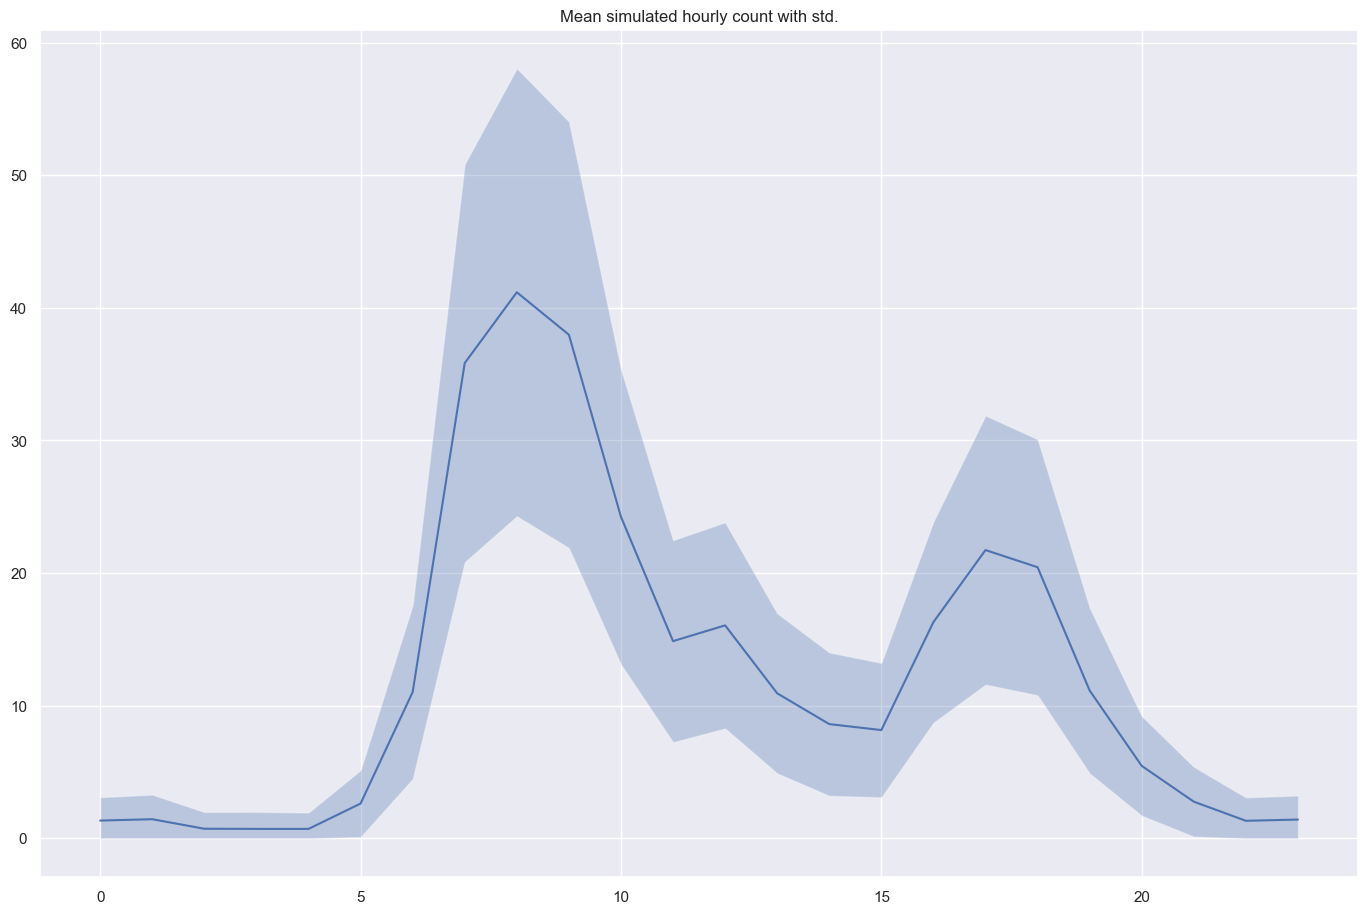

In [94]:
mean_count = observed_counts.mean(axis=0)
std_count = observed_counts.std(axis=0)

plt.plot(np.arange(24), mean_count)
plt.fill_between(np.arange(24), (mean_count - std_count).clip(min=0), mean_count + std_count, alpha=0.3)
plt.title("Mean simulated hourly count with std.")
plt.show()

## Model simulated data (just daily counts)

In [95]:
coords = {"days": day_ids}

with pm.Model(coords=coords) as sim_model_1:
    log_mu_d = pm.Normal("log_mu_d", mu=5.65, sigma=0.525)
    mu_d = pm.Deterministic("mu_d", np.exp(log_mu_d))
    
    log_alpha_d = pm.Normal("log_alpha_d", 1.875, 0.35)
    alpha_d = pm.Deterministic("alpha_d", np.exp(log_alpha_d))
    
    day_count = pm.NegativeBinomial("day_count", alpha=alpha_d, mu=mu_d, observed=observed_counts.sum(axis=1))
    
    trace = pm.sample_prior_predictive(1000)
    trace.extend(pm.sample(5000, tune=3000))
    trace.extend(pm.sample_posterior_predictive(trace))

Sampling: [day_count, log_alpha_d, log_mu_d]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_mu_d, log_alpha_d]


Sampling 4 chains for 3_000 tune and 5_000 draw iterations (12_000 + 20_000 draws total) took 3 seconds.
Sampling: [day_count]


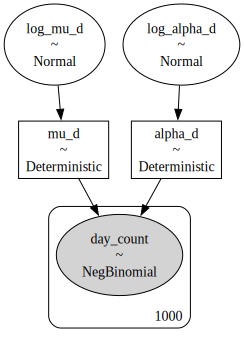

In [96]:
pm.model_to_graphviz(sim_model_1)

In [97]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

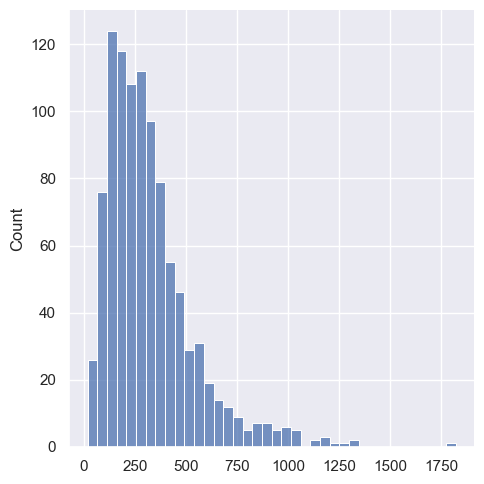

In [98]:
sns.displot(trace.prior_predictive.day_count.to_numpy()[0,:,0])

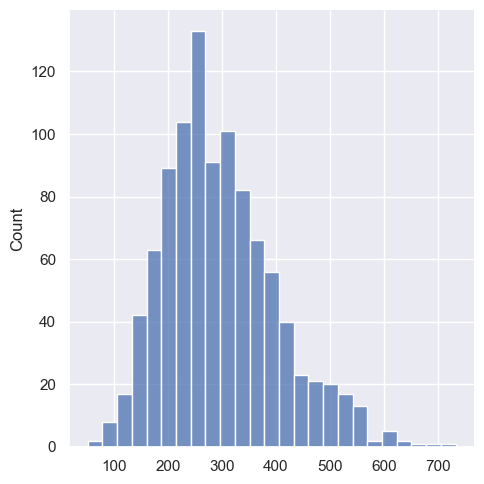

In [99]:
sns.displot(daily_count)

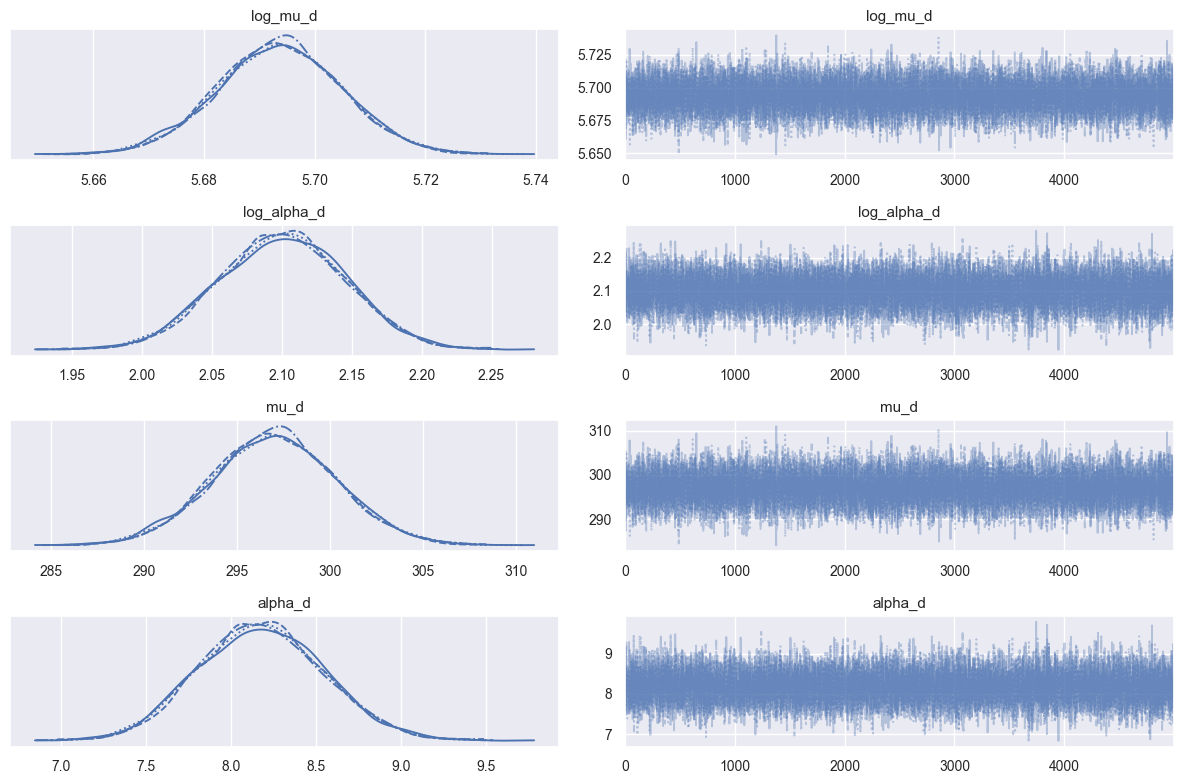

In [100]:
az.plot_trace(trace)
plt.tight_layout()

In [101]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
log_mu_d,5.694,0.011,5.673,5.715,0.000,0.000,19633.0,14817.0,1.0
log_alpha_d,2.100,0.045,2.014,2.183,0.000,0.000,20623.0,14522.0,1.0
mu_d,297.001,3.337,290.778,303.384,0.024,0.017,19633.0,14817.0,1.0
alpha_d,8.176,0.372,7.490,8.876,0.003,0.002,20623.0,14522.0,1.0


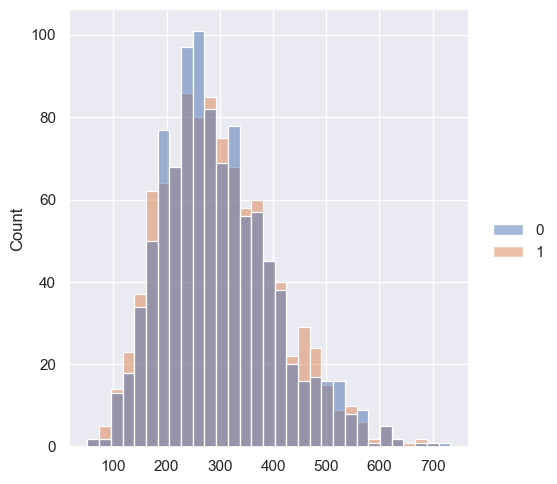

In [102]:
sns.displot(np.array([daily_count, trace.posterior_predictive.day_count.to_numpy()[0,:days,0]]).T)

## Model simulated data (with hourly counts)

Before DM: 7:30, 4433 divergences

After: 0:11, 16 divergences

After reparameterising neg bin: 0:23, 0 divergences

In [132]:
coords = {"hour": hours}

with pm.Model(coords=coords) as sim_model_2:
    observations = pm.MutableData("observations", observed_counts, dims=("day", "hour"))
    
    n_d = pm.Gamma("n_d", alpha=20, beta=0.05)
    p_d = pm.Beta("p_d", alpha=10, beta=10)
    day_count = pm.NegativeBinomial("day_count", n=n_d, p=p_d, observed=observations.sum(axis=1), dims="day")
    
    # Sample hourly counts from daily
    frac = pm.Dirichlet("frac", a=np.ones(24), dims="hour")
    conc = pm.LogNormal("conc", mu=1, sigma=1)
    hour_count = pm.DirichletMultinomial("hour_count", n=day_count, a=(frac*conc), observed=observations, dims=("day", "hour"))
    
    trace = pm.sample_prior_predictive(1000)
    trace.extend(pm.sample(5000, tune=3000))
    trace.extend(pm.sample_posterior_predictive(trace))

Sampling: [conc, day_count, frac, hour_count, n_d, p_d]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_d, p_d, frac, conc]


Sampling 4 chains for 3_000 tune and 5_000 draw iterations (12_000 + 20_000 draws total) took 141 seconds.


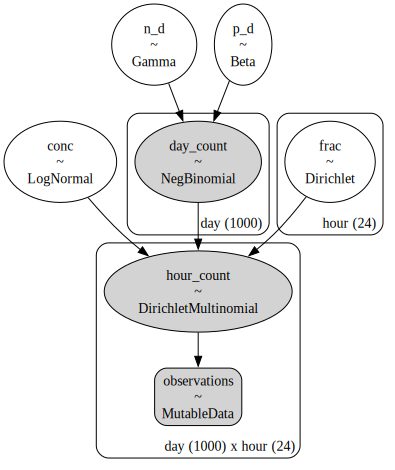

In [133]:
pm.model_to_graphviz(sim_model_2)

In [86]:
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

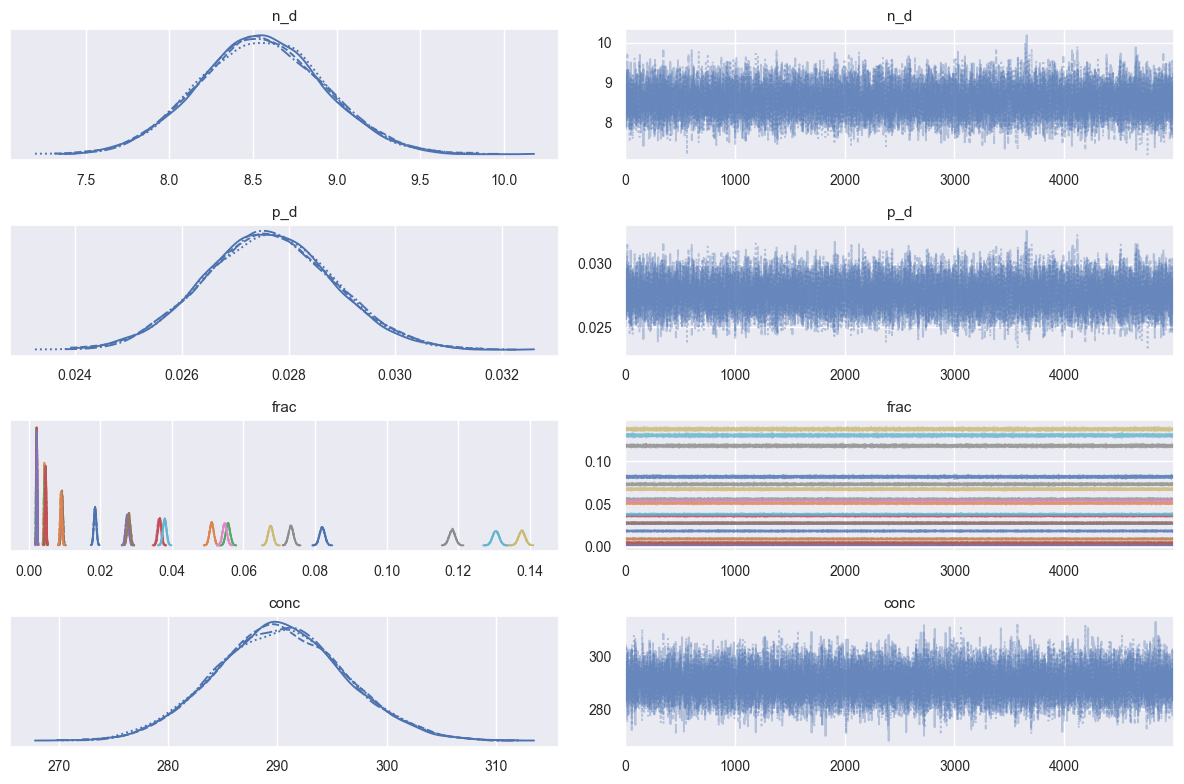

In [87]:
az.plot_trace(trace)
plt.tight_layout()

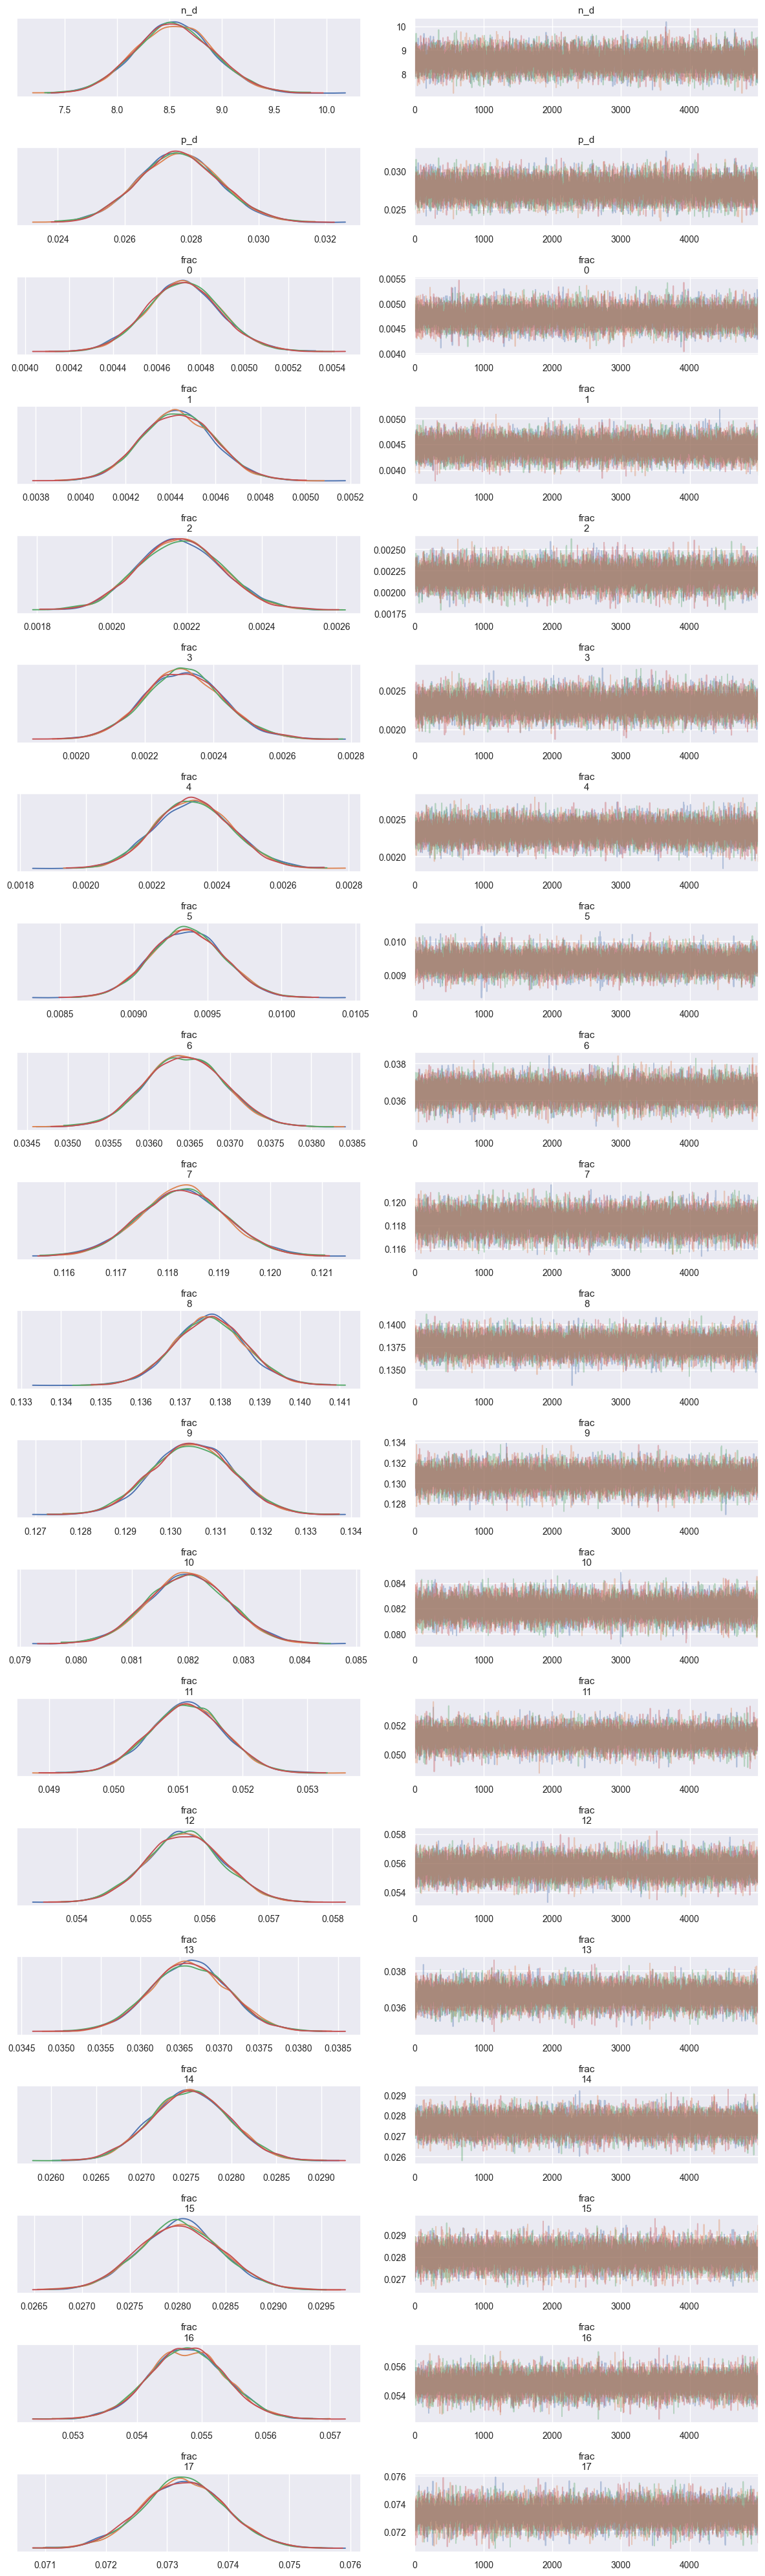

In [88]:
az.plot_trace(trace, compact=False)
plt.tight_layout()

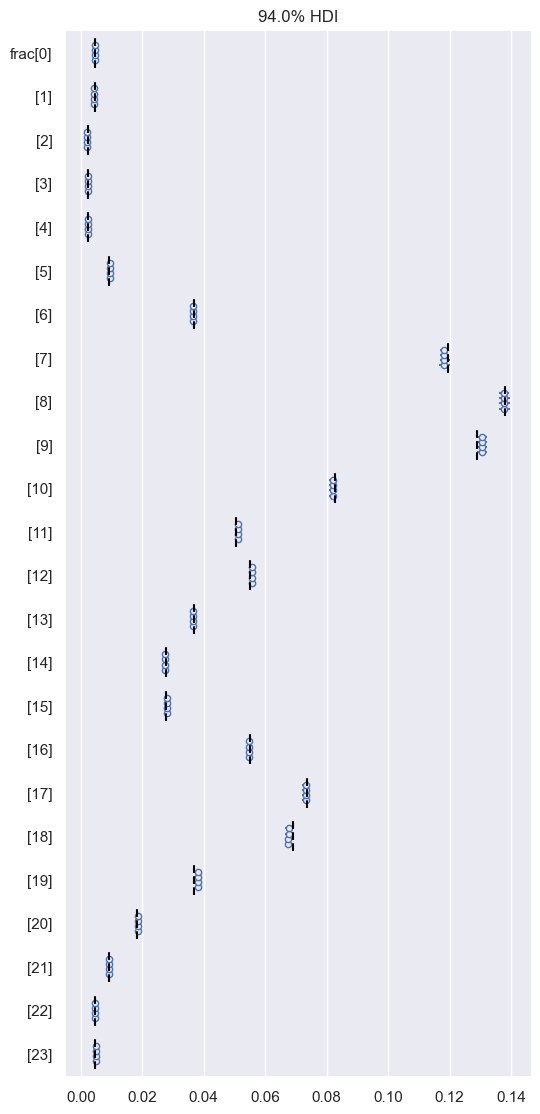

In [89]:
az.plot_forest(trace, var_names=["frac"])
for j, (y_tick, frac_j) in enumerate(zip(plt.gca().get_yticks(), reversed(daily_dist))):
    plt.vlines(frac_j, ymin=y_tick - 0.45, ymax=y_tick + 0.45, color="black", linestyle="--")

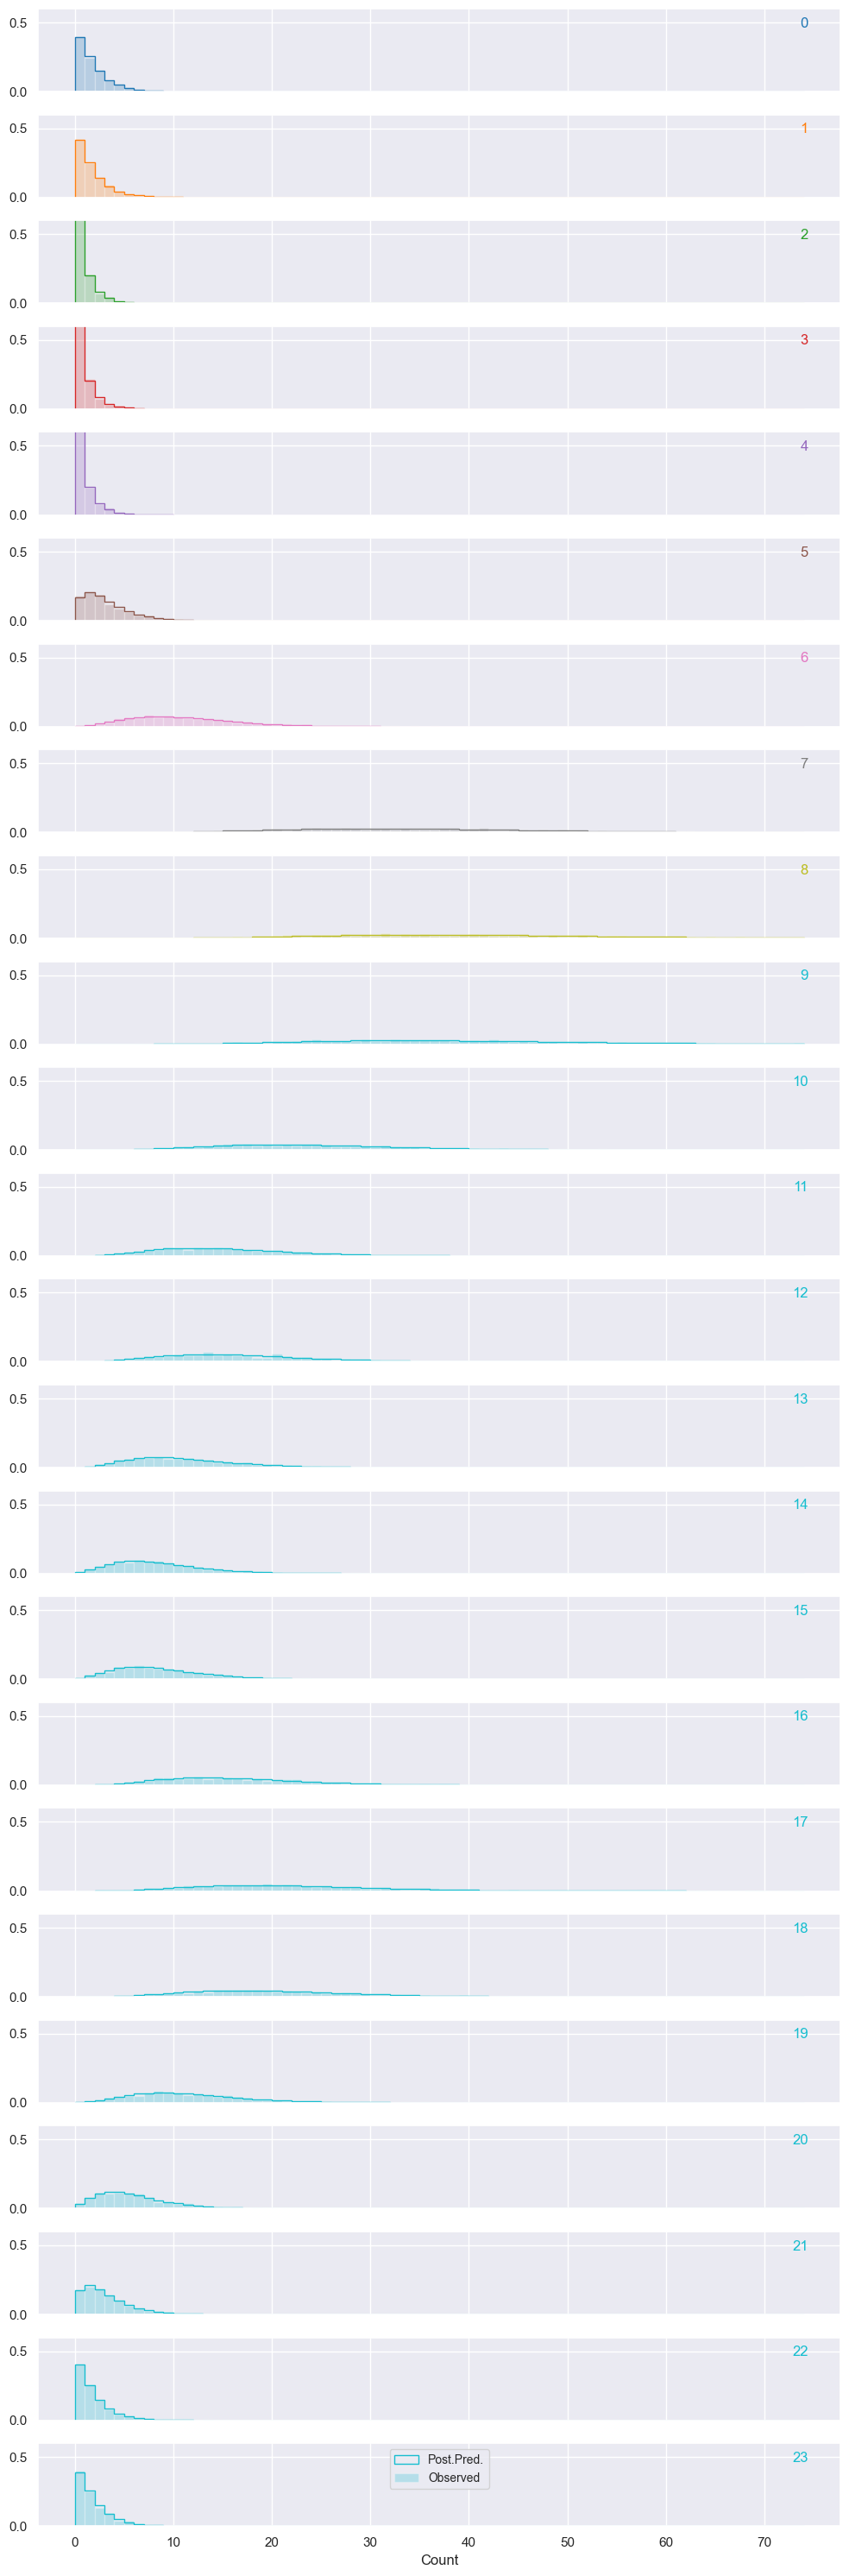

In [90]:
cmap = plt.get_cmap("tab10")

fig, axs = plt.subplots(24, 1, sharex=True, sharey=True, figsize=(10, 30))
for j, ax in enumerate(axs):
    c = cmap(j)
    ax.hist(
        trace.posterior_predictive.hour_count.sel(hour=hours[j]).values.flatten(),
        bins=np.arange(75),
        histtype="step",
        color=c,
        density=True,
        label="Post.Pred.",
    )
    ax.hist(
        (trace.observed_data.hour_count.sel(hour=hours[j]).values.flatten()),
        bins=np.arange(75),
        color=c,
        density=True,
        alpha=0.25,
        label="Observed",
    )
    # ax.axvline(
    #     day_dist_samples[j] * 300,
    #     color=c,
    #     lw=1.0,
    #     alpha=0.45,
    #     label="True",
    # )
    ax.annotate(
        f"{hours[j]}",
        xy=(0.96, 0.9),
        xycoords="axes fraction",
        ha="right",
        va="top",
        color=c,
    )

axs[-1].legend(loc="upper center", fontsize=10)
axs[-1].set_xlabel("Count")
axs[-1].set_yticks([0, 0.5, 1.0])
axs[-1].set_ylim(0, 0.6)
plt.tight_layout();

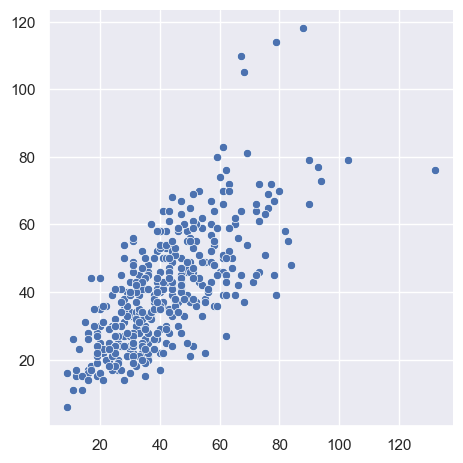

In [91]:
sns.relplot(
    x=trace.posterior_predictive.hour_count.sel(hour="8").to_numpy()[0,:400,0],
    y=trace.posterior_predictive.hour_count.sel(hour="9").to_numpy()[0,:400,0],
)

## Generating samples for real data

Data taken from 2022 Thorndon Quay outgoing count on weekdays (Monday - Friday). 

Results show good ability to fit the general distribution, but poor sampling in lower extreme likely due to absence of predictors in model (e.g. weather effects). 

In [122]:
real_data_df = (
    pl.read_parquet(
        "../data/counter_data.parquet"
    ).with_columns(
        pl.col("weekday") - 1,
        pl.col("count_outgoing").fill_null(0),
        (pl.col("record_time").dt.date() - datetime.date(year=2022, month=1, day=1)).dt.days().alias("day_in_year")
    ).filter(
        (pl.col("year") == 2022) &
        (pl.col("site_name") == "Thorndon Quay") &
        (pl.col("weekday") < 5)
    )
)


In [129]:
real_observations = []

for i,group in real_data_df.group_by(pl.col("day_in_year"), maintain_order=True):
    real_observations.append(group.select(pl.col("count_outgoing")).to_numpy().flatten())
    
real_observations = np.array(real_observations)

In [134]:
with sim_model_2:
    pm.set_data(
        {"observations": real_observations}
    )
    real_trace = pm.sample(5000, tune=3000)
    real_trace.extend(pm.sample_posterior_predictive(real_trace))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n_d, p_d, frac, conc]


Sampling 4 chains for 3_000 tune and 5_000 draw iterations (12_000 + 20_000 draws total) took 46 seconds.
Sampling: [day_count, hour_count]


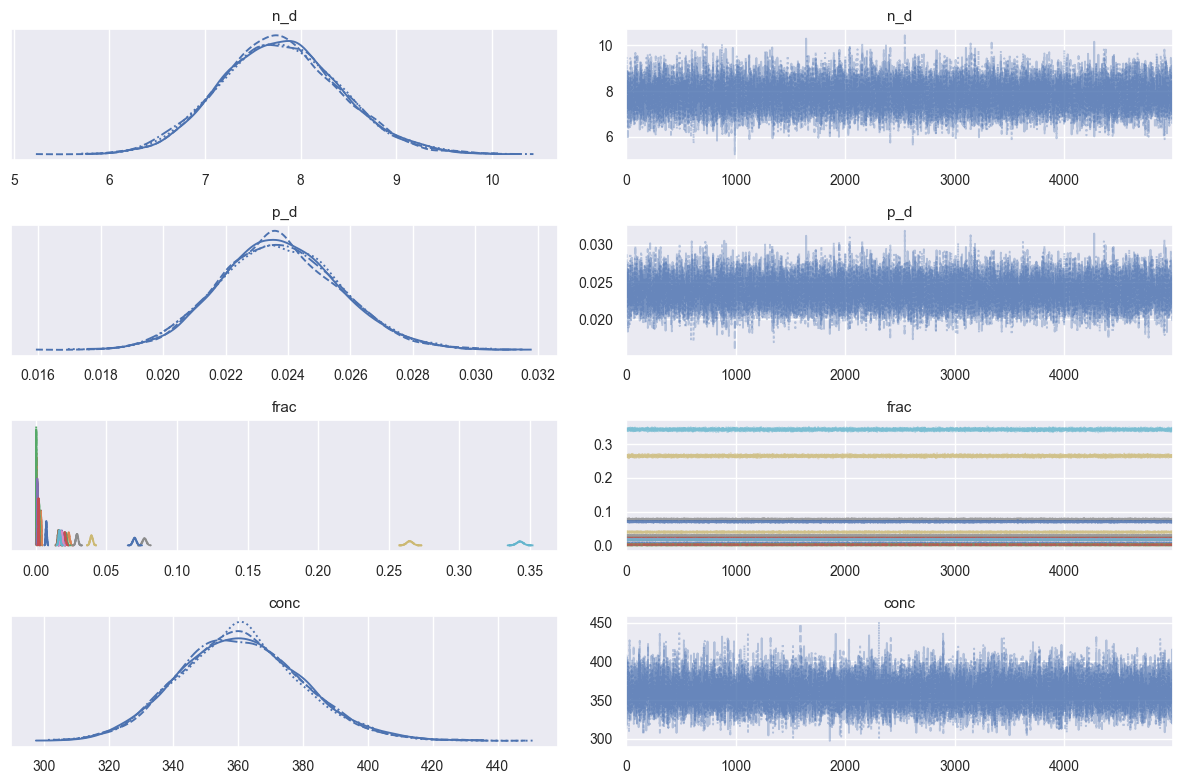

In [135]:
az.plot_trace(real_trace)
plt.tight_layout()

## Inspecting similarity of 8am/9am correlation with observed

This was very poor in the GP model, where there was no significant correlation between the two. In this model the correlation is apparent and is visually similar to the observed.

Note that the observation values go right down to near-zero, but posterior predictions don't. This is likely due to effects of weather, holidays, and sensor error which are not currently modelled.

(0.0, 250.0)

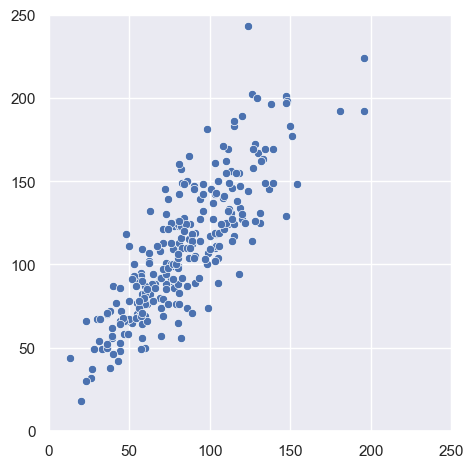

In [147]:
sns.relplot(
    x=real_trace.posterior_predictive.hour_count.sel(hour="8").to_numpy()[0,260:520,0],
    y=real_trace.posterior_predictive.hour_count.sel(hour="9").to_numpy()[0,260:520,0],
)
plt.xlim(0,250)
plt.ylim(0,250)

(0.0, 250.0)

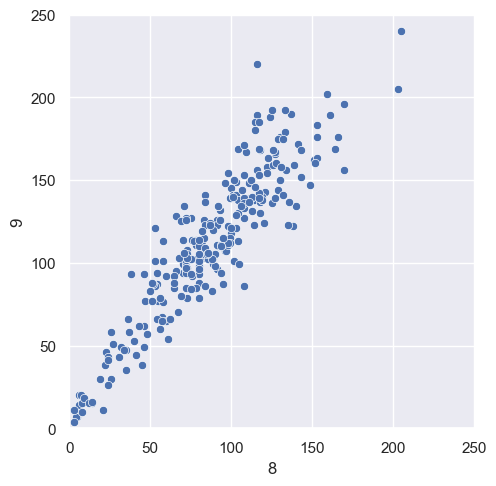

In [148]:
sns.relplot(
    real_data_df.filter(
        (pl.col("hour") >= 8) &
        (pl.col("hour") <= 9)
    ).pivot(index=["year", "month", "day"], columns="hour", values=["count_outgoing"]),
    x="8",
    y="9"
)
plt.xlim(0,250)
plt.ylim(0,250)